### Problem 1 - a simple, scary distribution

Worked example of a Hierarchical Bayesian Model.  Make some data from a simple Gaussian distribution and add on some observational uncertainty. We will make the data look like a distribution of the scare score of monsters working at Monsters Incororated$^{\rm TM}$

The distribution of the scare score of the monsters will be defined as:

$S_{\rm monsters} \sim \mathcal{N}(60000, 1000)$.

If we have $N$ monsters which we will label with the index $i = 1,2,..., N$ then

$S_{\rm i, true} \sim \mathcal{N}(60000, 1000)$.

The scare score is determined by how scared the child is, however the machine measuring this is broken and so has uncertainty of 1500 points.  The measured score will be:

$S_{i, {\rm obs}} \sim \mathcal{N}(S_{i, {\rm true}}, 1500)$.

Let's set up this data.

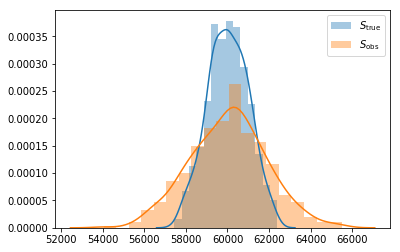

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 500       # Number of samples from distribution
Smu =  60000    # Mean (mu)
Ssigma = 1000
S_true = np.random.randn(N) * Ssigma + Smu    # eq to S ~N(50000, 1000)
sigma_S_obs = np.ones(N) * 1500            # array of 500 50s for variation in Sobs of 50 points
S_obs = S_true + np.random.randn(N) * sigma_S_obs    # Sobs is normally dist'd w Strue as mean and variance 50

ax = sns.distplot(S_true, label=r'$S_{\rm true}$')
ax = sns.distplot(S_obs, label=r'$S_{\rm obs}$')
ax.legend()

So if we were to try an estimate the spread of scare scores from the machine's data just by measuring the standard deviation we would find an overestimate.

In [7]:
print(f'Machine data: mean = {S_obs.mean():.4f}; std = {S_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {S_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {S_true.mean():.4f}; std = {S_true.std(ddof=1):.4f};  ' +
      f'error on mean = {S_true.std(ddof=1) / N**0.5:.4f}')

Machine data: mean = 60046.3688; std = 1845.7793; error on mean = 82.5458
True data: mean = 60023.9045; std = 980.8818;  error on mean = 43.8664


What we want is a method that takes the measured data and estimates the spread in the true data. We will look at a HBM using latent variables.

Let's jump right in a build an acyclic graph to visualise our problem:

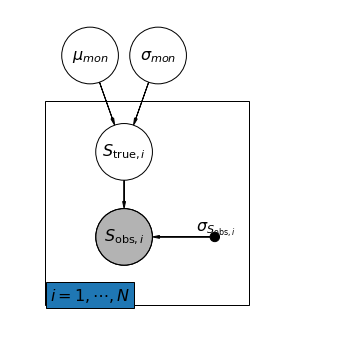

In [8]:
''' You might need to pip install daft and update matplotlib to get this to work '''

from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu_{mon}$", 0.7, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{mon}$", 1.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("S_true", r"$S_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("S_obs", r"$S_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("err", r"$\sigma_{S_{{\rm obs},i}}$", 1.8, 1.0, fixed=True, offset=[0.4,0.4]))
# Add in the edges.
pgm.add_edge("mu", "S_true")
pgm.add_edge("sigma", "S_true")
pgm.add_edge("S_true", "S_obs")
pgm.add_edge("err", "S_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The monsters' scare scores are assumed to follow a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ which are both unknowns.  Each monster in $N$ has an index $i$.  Each monster also has a true scare score, which is an unknown, and an observed scare score which is known with some uncertainty $\sigma_{S_{{\rm obs},i}}$.  We then treat $\mu$, $\sigma$, and $[S_{{\rm true}, 1}, S_{{\rm true}, 2}, ..., S_{{\rm true}, N}]$ as parameters that are to be estimated.

We have the following constraints:

$S_{\rm true} \sim \mathcal{N}(S_{\rm obs}, \sigma_{S_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$S_{\rm true} \sim \mathcal{N}(\mu, \sigma)$.

Which is to say, that the distribution of $S_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the monsters but are designed to be weakly informative:

$\mu \sim \mathcal{N}({60000, 1000})$,

and 

$\sigma \sim {\rm Lognormal}(\log(1000), 0.4)$,

Lognormal distribution:

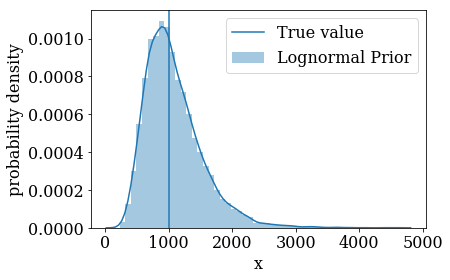

In [9]:
x = np.random.lognormal(np.log(1000), 0.4, 10000)
ax = sns.distplot(x, label='Lognormal Prior')
ax.axvline(Ssigma, label='True value')
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.legend()

In [10]:
code = '''
data {
    int N;  // N monsters
    real Sobs[N];
    real sigmaSobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Strue[N];
}
model {
    Strue ~ normal(Sobs, sigmaSobs);
    Strue ~ normal(mu, sigma);
    mu ~ normal(60000, 1000);
    sigma ~ lognormal(log(1000), 0.4);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_78e4ca35e8b85b7e813cd91452280eff NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp4mqhp6o6/stanfit4anon_model_78e4ca35e8b85b7e813cd91452280eff_102424924743741824.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


The stan code is written here as a string that is passed to the StanModel object.

The first section defines the data.  Both Sobs and sigmaSobs are arrays of length N with type real.

The second section defines the parameters.  Note here we have included a lower limit on sigma of zero - negative spread does not mean much here.  We have also defined an array of parameters!  Strue is an array of length N.  Stan understands this and treats each value in the array as a parameter (see below).

The final section defines the model.  Here we have just made the statements we defined above about what the constraints we have are.  There are two hyperpriors on mu and sigma.  And then there are the constraints on Strue from Sobs and the constraint on Strue from mu and sigma.

The code 'sm = pystan.StanModel(model_code=code)' compiles the stan model for us to call later.

We can now run the code.

In [11]:
nchains = 4
data = {'N': N,
       'Sobs': S_obs,
       'sigmaSobs': sigma_S_obs}
fit = sm.sampling(data=data, iter=2000, chains=nchains)

Running the code is simple.  We first make a choice as to how many chains we want to run in Stan's HMC sampler.  A default for testing is 4 chains but you might want to increase that number for important work.

We then define a dictionary called data that holds that data objects defined in the model so that these can be passed in to the sampling method.

Finally, we fit by calling sm.sampling() passing in data, running for 2000 iterations, and setting the number of chains.

You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took less than 2 seconds (note the compliation takes significantly longer).

The fit object has a plot method so we can view the results.

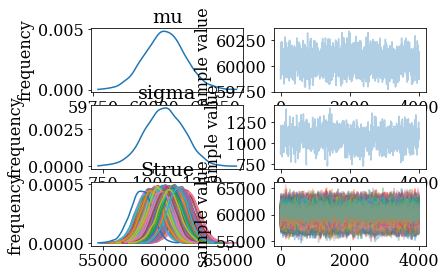

In [12]:
fit.plot()
plt.show()

We can print the fit object to see lots of useful information.  Perhaps most importantly, Rhat gives a measure of convergence.  The closer Rhat is to unity the better.  Experience suggests that all Rhat's less than 1.02 should give reasonable results.

In [13]:
print(fit)

Inference for Stan model: anon_model_78e4ca35e8b85b7e813cd91452280eff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          6.0e4    1.99  82.17  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4   1708    1.0
sigma      1060.1    4.81  99.87 858.93 993.96 1061.1 1129.0 1250.9    431   1.02
Strue[1]    6.1e4   12.29 872.24  5.9e4  6.0e4  6.1e4  6.2e4  6.3e4   5033    1.0
Strue[2]    6.0e4   11.14 891.15  5.9e4  6.0e4  6.0e4  6.1e4  6.2e4   6396    1.0
Strue[3]    6.0e4   10.66 868.19  5.8e4  5.9e4  6.0e4  6.0e4  6.1e4   6638    1.0
Strue[4]    6.0e4   10.12 862.25  5.9e4  6.0e4  6.0e4  6.1e4  6.2e4   7261    1.0
Strue[5]    6.0e4   10.87 870.78  5.9e4  6.0e4  6.0e4  6.1e4  6.2e4   6417    1.0
Strue[6]    6.0e4     9.6 840.69  5.8e4  6.0e4  6.0e4  6.1e4  6.2e4   7668    1.0
Strue[7]    6.0e4   11.13 863.83  5.9e4  6.0e4  6.0e4  6.1e4  6.2e4   602

We can also study the detail of the fit using corner.

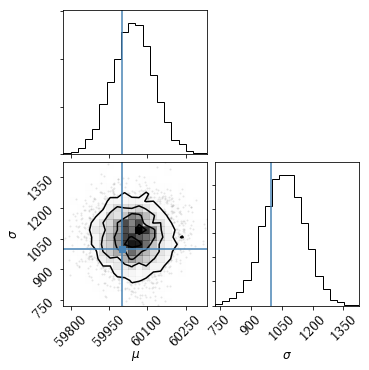

In [15]:
import corner
rc("font", family="serif", size=12)
data = np.vstack([fit['mu'], fit['sigma']]).T
corner.corner(data, labels=[r'$\mu$', r'$\sigma$'], truths=[Smu, Ssigma])
plt.show()

We can see that we do a good job of recovering the real properties of the population (Strue).  

Here we have worked through a simple example of Hirarchical modelling in Stan.  We have treated this very simply and shown how to take a first look at the fit results of a StanModel sampling result.

In the next example, I will demonstrate another simple problem but with a sampling 'trick' that will speed up convergence considerably for lots of different applications of this simple problem.